# Analyzing New York City subway data 

#### Author: Sushant N. More

### Data from web.mta.info/developers/turnstile.html.  Also, using a data file from weather underground obtained from Udacity website

#### Revision history: 

Sept. 15, 2017: Started writing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
import csv

## Data cleaning

We will be analysing subway data from MTA's website for the month of May 2011 (because later I want to relate this to weather data and the weather data I have is for the month of May 2011). 

This is real-world data.  We can expect significant effort in cleaning and formatting the data. The data for a given month is in four different files.  Let's start by looking at the files to see how data is arranged. 

In [2]:
turnstile_df1 = pd.read_csv('./data/turnstile_110507_from_web_mta_info.txt')

In [3]:
turnstile_df1.head()

,A002,R051,02-00-00,04-30-11,00:00:00,REGULAR,003143506,001087907,04-30-11.1,04:00:00,...,05-01-11,00:00:00.1,REGULAR.6,003144312,001088151,05-01-11.1,04:00:00.1,REGULAR.7,003144335,001088159
0,A002,R051,02-00-00,05-01-11,08:00:00,REGULAR,3144353,1088177,05-01-11,12:00:00,...,05-02-11,08:00:00,REGULAR,3144941.0,1088420.0,05-02-11,12:00:00,REGULAR,3145094.0,1088753.0
1,A002,R051,02-00-00,05-02-11,16:00:00,REGULAR,3145337,1088823,05-02-11,20:00:00,...,05-03-11,16:00:00,REGULAR,3146790.0,1089417.0,05-03-11,20:00:00,REGULAR,3147615.0,1089478.0
2,A002,R051,02-00-00,05-04-11,00:00:00,REGULAR,3147798,1089515,05-04-11,04:00:00,...,05-05-11,00:00:00,REGULAR,3149281.0,1090139.0,05-05-11,04:00:00,REGULAR,3149297.0,1090145.0
3,A002,R051,02-00-00,05-05-11,08:00:00,REGULAR,3149331,1090257,05-05-11,09:04:33,...,05-05-11,12:00:00,OPEN,3149494.0,1090579.0,05-05-11,16:00:00,DOOR,3149805.0,1090652.0
4,A002,R051,02-00-00,05-05-11,20:00:00,REGULAR,3150639,1090714,05-06-11,00:00:00,...,05-06-11,20:00:00,REGULAR,3152200.0,1091283.0,NaN,NaN,NaN,NaN,NaN


The data is not conviniently arranged as expected.  And it's difficult to get sense of it by loading it into pandas data frame. Let's try looking at the file contents directly.

In [4]:
with open("./data/turnstile_110507_from_web_mta_info.txt") as myfile:
    print myfile.readlines()[0:4] 

['A002,R051,02-00-00,04-30-11,00:00:00,REGULAR,003143506,001087907,04-30-11,04:00:00,REGULAR,003143547,001087915,04-30-11,08:00:00,REGULAR,003143563,001087935,04-30-11,12:00:00,REGULAR,003143646,001088024,04-30-11,16:00:00,REGULAR,003143865,001088083,04-30-11,20:00:00,REGULAR,003144181,001088132,05-01-11,00:00:00,REGULAR,003144312,001088151,05-01-11,04:00:00,REGULAR,003144335,001088159              \r\n', 'A002,R051,02-00-00,05-01-11,08:00:00,REGULAR,003144353,001088177,05-01-11,12:00:00,REGULAR,003144424,001088231,05-01-11,16:00:00,REGULAR,003144594,001088275,05-01-11,20:00:00,REGULAR,003144808,001088317,05-02-11,00:00:00,REGULAR,003144895,001088328,05-02-11,04:00:00,REGULAR,003144905,001088331,05-02-11,08:00:00,REGULAR,003144941,001088420,05-02-11,12:00:00,REGULAR,003145094,001088753              \r\n', 'A002,R051,02-00-00,05-02-11,16:00:00,REGULAR,003145337,001088823,05-02-11,20:00:00,REGULAR,003146168,001088888,05-03-11,00:00:00,REGULAR,003146322,001088918,05-03-11,04:00:00,REGULAR

As we can see, there are numerous data points included in each row of the MTA Subway turnstile text file. 

We want to write a function that will update each row in the text file so there is only one entry per row. So a single row from the input file will generate multiple rows. For instance the first row displayed in the above file will turn into following set of rows.

A002,R051,02-00-00,04-30-11,00:00:00,REGULAR,003143506,001087907,
A002,R051,02-00-00,04-30-11,04:00:00,REGULAR,003143547,001087915,
A002,R051,02-00-00,04-30-11,08:00:00,REGULAR,003143563,001087935,
A002,R051,02-00-00,04-30-11,12:00:00,REGULAR,003143646,001088024,
A002,R051,02-00-00,04-30-11,16:00:00,REGULAR,003143865,001088083,
A002,R051,02-00-00,04-30-11,20:00:00,REGULAR,003144181,001088132,
A002,R051,02-00-00,05-01-11,00:00:00,REGULAR,003144312,001088151,
A002,R051,02-00-00,05-01-11,04:00:00,REGULAR,003144335,001088159

The first three elements in the input line -- A002,R051,02-00-00 -- are repeated for each of the 8 lines in the ouput file. 

Along with the above, following two preemptive operations have been done at the file below.  

1) From the time column, made a new column for Hour.  So that I can later on plot hourly data and so on

2) I wanna combine this with weather data which has the date format as yyyy-mm-dd. So I changed the date format here. 

As I found out the hard way, given the size of the data, it is really time-consuming to do in-memory computations.

In [5]:
fin1 = open("./data/turnstile_110507_from_web_mta_info.txt", 'r')
fout1 = open("./data/updated_turnstile_110507_from_web_mta_info.txt", 'w')

reader = csv.reader(fin1, delimiter = ',', quoting=csv.QUOTE_NONE)
writer = csv.writer(fout1, delimiter = ',', quoting=csv.QUOTE_NONE)

for line in reader:
    
    record1 = line[0]
    record2 = line[1]
    record3 = line[2]
    
    length = len(line)
    
    nn = (length - 1 - 7) / 5
    
    for i in range(0, nn + 1):
        
        date = line[5*i + 3]
        
        date_formatted = '20' + date.split('-')[2] + '-' + date.split('-')[0] + '-' + date.split('-')[1]
        
        lineToWrite = [record1, record2, record3, date_formatted, \
                         line[5*i + 4], int(line[5*i + 4].split(':')[0]), \
                       line[5*i + 5], line[5*i + 6], line[5*i + 7] ]
        
        writer.writerow(lineToWrite)

fin1.close()
fout1.close()

Check to see if the updated file looks as expected

In [6]:
with open("./data/updated_turnstile_110507_from_web_mta_info.txt") as myfile:
    print myfile.readlines()[0:4] 

['A002,R051,02-00-00,2011-04-30,00:00:00,0,REGULAR,003143506,001087907\r\n', 'A002,R051,02-00-00,2011-04-30,04:00:00,4,REGULAR,003143547,001087915\r\n', 'A002,R051,02-00-00,2011-04-30,08:00:00,8,REGULAR,003143563,001087935\r\n', 'A002,R051,02-00-00,2011-04-30,12:00:00,12,REGULAR,003143646,001088024\r\n']


Let's fix the data in other files all at once

In [7]:
fileloc = './data/'
filenames = [fileloc + 'turnstile_110514_from_web_mta_info.txt', \
            fileloc + 'turnstile_110521_from_web_mta_info.txt', \
            fileloc + 'turnstile_110528_from_web_mta_info.txt', \
            fileloc + 'turnstile_110604_from_web_mta_info.txt']

In [8]:
for k in range(0, len(filenames)):
    
    f_in = open(filenames[k], 'r')
    f_out = open(filenames[k][0:len(fileloc)] + 'updated_' + filenames[k][len(fileloc):], 'w')
    
    reader_in = csv.reader(f_in, delimiter = ',', quoting=csv.QUOTE_NONE)
    writer_out = csv.writer(f_out, delimiter = ',', quoting=csv.QUOTE_NONE)

    for line in reader_in:

        record1 = line[0]
        record2 = line[1]
        record3 = line[2]

        length = len(line)

        nn = (length - 1 - 7) / 5

        for i in range(0, nn + 1):

            date = line[5*i + 3]
        
            date_formatted = '20' + date.split('-')[2] + '-' + date.split('-')[0] + '-' + date.split('-')[1]
        
            lineToWrite = [record1, record2, record3, date_formatted, \
                             line[5*i + 4], int(line[5*i + 4].split(':')[0]), \
                           line[5*i + 5], line[5*i + 6], line[5*i + 7] ]

            writer_out.writerow(lineToWrite)
            
    f_in.close()
    f_out.close()

As mentioned in the field description file, the entries in the column are as follows: 

C/A = Control Area (e.g., A002)

UNIT = Remote Unit for a station (e.g., R051)

SCP = Subunit Channel Position represents an specific address for a device (02-00-00)

DATEn = Represents the date (MM-DD-YY)

TIMEn = Represents the time (hh:mm:ss) for a scheduled audit event

DEScn = Represent the "REGULAR" scheduled audit event (occurs every 4 hours)

ENTRIESn = The comulative entry register value for a device

EXISTn = The cumulative exit register value for a device

Let's combine all the input files we generated into a single file and have a header row at the top describing the entries

In [9]:
filenamesUpdated = [fileloc + 'updated_turnstile_110507_from_web_mta_info.txt', \
            fileloc + 'updated_turnstile_110514_from_web_mta_info.txt', \
            fileloc + 'updated_turnstile_110521_from_web_mta_info.txt', \
            fileloc + 'updated_turnstile_110528_from_web_mta_info.txt', \
            fileloc + 'updated_turnstile_110604_from_web_mta_info.txt'       ]

In [10]:
with open(fileloc + 'turnstile_master_data.csv', 'w') as master_file:
    master_file.write('C/A,UNIT,SCP,DATEn,TIMEn,Hour,DESCn,ENTRIESn,EXITSn\n')
    
    for name in filenamesUpdated:
        with open(name) as infile:
            for line in infile:
                master_file.write(line)

In [11]:
with open("./data/turnstile_master_data.csv") as myfile:
    print myfile.readlines()[0:4] 

['C/A,UNIT,SCP,DATEn,TIMEn,Hour,DESCn,ENTRIESn,EXITSn\n', 'A002,R051,02-00-00,2011-04-30,00:00:00,0,REGULAR,003143506,001087907\r\n', 'A002,R051,02-00-00,2011-04-30,04:00:00,4,REGULAR,003143547,001087915\r\n', 'A002,R051,02-00-00,2011-04-30,08:00:00,8,REGULAR,003143563,001087935\r\n']


In [12]:
turnstile_df = pd.read_csv('./data/turnstile_master_data.csv')

In [13]:
turnstile_df.head()

,C/A,UNIT,SCP,DATEn,TIMEn,Hour,DESCn,ENTRIESn,EXITSn
0,A002,R051,02-00-00,2011-04-30,00:00:00,0,REGULAR,3143506,1087907
1,A002,R051,02-00-00,2011-04-30,04:00:00,4,REGULAR,3143547,1087915
2,A002,R051,02-00-00,2011-04-30,08:00:00,8,REGULAR,3143563,1087935
3,A002,R051,02-00-00,2011-04-30,12:00:00,12,REGULAR,3143646,1088024
4,A002,R051,02-00-00,2011-04-30,16:00:00,16,REGULAR,3143865,1088083


The field description key says that the 'REGULAR' in the DESCn column represents a scheduled audit event. So, let's keep only the entries which have 'REGULAR' in the DESCn column. 

In [14]:
turnstile_df_reg = turnstile_df.loc[turnstile_df['DESCn'] == 'REGULAR']

In [15]:
turnstile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069902 entries, 0 to 1069901
Data columns (total 9 columns):
C/A         1069902 non-null object
UNIT        1069902 non-null object
SCP         1069902 non-null object
DATEn       1069902 non-null object
TIMEn       1069902 non-null object
Hour        1069902 non-null int64
DESCn       1069902 non-null object
ENTRIESn    1069902 non-null int64
EXITSn      1069902 non-null int64
dtypes: int64(3), object(6)
memory usage: 73.5+ MB


## Merge the weather data

In [16]:
weather_df = pd.read_csv('./data/weather-underground.csv')

In [17]:
weather_df.head()

,date,maxpressurem,maxdewptm,maxpressurei,maxdewpti,since1julheatingdegreedaysnormal,heatingdegreedaysnormal,since1sepcoolingdegreedaysnormal,hail,since1julsnowfallm,...,precipi,snowfalli,since1jancoolingdegreedaysnormal,precipm,snowfallm,thunder,monthtodateheatingdegreedays,meantempi,maxvism,meantempm
0,2011-05-01,1026,6,30.31,42,4646,8,NaN,0,157.23,...,0.0,0.0,13,0.0,0.0,0,5,60,16,16
1,2011-05-02,1026,10,30.31,50,4653,7,NaN,0,157.23,...,0.0,0.0,14,0.0,0.0,0,13,57,16,14
2,2011-05-03,1021,15,30.14,59,4660,7,NaN,0,157.23,...,0.0,0.0,15,0.0,0.0,0,13,65,16,18
3,2011-05-04,1017,14,30.03,57,4667,7,NaN,0,157.23,...,0.5,0.0,16,12.7,0.0,0,23,55,16,13
4,2011-05-05,1016,4,30.01,39,4673,6,NaN,0,157.23,...,0.0,0.0,17,0.0,0.0,0,32,56,16,13


In [18]:
weather_df.shape

(30, 70)

In [19]:
turnstile_df_reg.DATEn.unique()

array(['2011-04-30', '2011-05-01', '2011-05-02', '2011-05-03',
       '2011-05-04', '2011-05-05', '2011-05-06', '2011-05-07',
       '2011-05-08', '2011-05-09', '2011-05-10', '2011-05-11',
       '2011-05-12', '2011-05-13', '2011-05-14', '2011-05-15',
       '2011-05-16', '2011-05-17', '2011-05-18', '2011-05-19',
       '2011-05-20', '2011-05-21', '2011-05-22', '2011-05-23',
       '2011-05-24', '2011-05-25', '2011-05-26', '2011-05-27',
       '2011-05-28', '2011-05-29', '2011-05-30', '2011-05-31',
       '2011-06-01', '2011-06-02', '2011-06-03'], dtype=object)

In [20]:
turnstile_df_reg.DATEn.nunique()

35

In [21]:
weather_df.date.unique()

array(['2011-05-01', '2011-05-02', '2011-05-03', '2011-05-04',
       '2011-05-05', '2011-05-06', '2011-05-07', '2011-05-08',
       '2011-05-09', '2011-05-10', '2011-05-11', '2011-05-12',
       '2011-05-13', '2011-05-14', '2011-05-15', '2011-05-16',
       '2011-05-17', '2011-05-18', '2011-05-19', '2011-05-20',
       '2011-05-21', '2011-05-22', '2011-05-23', '2011-05-24',
       '2011-05-25', '2011-05-26', '2011-05-27', '2011-05-28',
       '2011-05-29', '2011-05-30'], dtype=object)

Before we go ahead with combining the data, let's drop the dates from April and June which have crept into our turnstile data

In [22]:
turnstile_df_reg = turnstile_df_reg.loc[~(turnstile_df_reg['DATEn'].isin(['2011-04-30', \
                                                                         '2011-05-31', '2011-06-01',\
                                                                         '2011-06-02', '2011-06-03']))]

In [24]:
turnstile_df_reg.DATEn.nunique()

30

It's clear that many of the features in weather_df are not gonna have an effect on subway ridership. Also, getting rid of columns which have the same value throughout -- for instance snowfall = 0 (it's the month of May!). So let's pick columns which could be relevant. 

In [25]:
weather_df_relevant = weather_df[['date', 'maxpressurei', 'maxdewpti', 'mindewpti', 'minpressurei', 'meandewpti', \
                                 'meanpressurei', 'fog', 'rain', 'meanwindspdi', 'mintempi', 'meantempi', \
                                 'maxtempi', 'precipi', 'thunder']]

In [26]:
weather_df_relevant.head()

,date,maxpressurei,maxdewpti,mindewpti,minpressurei,meandewpti,meanpressurei,fog,rain,meanwindspdi,mintempi,meantempi,maxtempi,precipi,thunder
0,2011-05-01,30.31,42,35,30.23,39,30.27,0,0,5,50,60,69,0.0,0
1,2011-05-02,30.31,50,39,30.13,45,30.22,0,0,5,50,57,63,0.0,0
2,2011-05-03,30.14,59,50,29.94,54,30.05,0,0,7,55,65,75,0.0,0
3,2011-05-04,30.03,57,38,29.91,48,29.97,0,1,6,46,55,64,0.5,0
4,2011-05-05,30.01,39,22,29.89,31,29.95,0,0,9,46,56,65,0.0,0


In [27]:
turnstile_df_reg.columns

Index([u'C/A', u'UNIT', u'SCP', u'DATEn', u'TIMEn', u'Hour', u'DESCn',
       u'ENTRIESn', u'EXITSn'],
      dtype='object')

In [28]:
weather_df_relevant = weather_df_relevant.rename(columns = {'date': 'DATEn'})

** Make the columnname for the date column match **

In [29]:
weather_df_relevant.head()

,DATEn,maxpressurei,maxdewpti,mindewpti,minpressurei,meandewpti,meanpressurei,fog,rain,meanwindspdi,mintempi,meantempi,maxtempi,precipi,thunder
0,2011-05-01,30.31,42,35,30.23,39,30.27,0,0,5,50,60,69,0.0,0
1,2011-05-02,30.31,50,39,30.13,45,30.22,0,0,5,50,57,63,0.0,0
2,2011-05-03,30.14,59,50,29.94,54,30.05,0,0,7,55,65,75,0.0,0
3,2011-05-04,30.03,57,38,29.91,48,29.97,0,1,6,46,55,64,0.5,0
4,2011-05-05,30.01,39,22,29.89,31,29.95,0,0,9,46,56,65,0.0,0


In [30]:
turnstile_weather_df = pd.merge(turnstile_df_reg, weather_df_relevant, on = 'DATEn', how = 'outer')

In [31]:
turnstile_weather_df.head()

,C/A,UNIT,SCP,DATEn,TIMEn,Hour,DESCn,ENTRIESn,EXITSn,maxpressurei,...,meandewpti,meanpressurei,fog,rain,meanwindspdi,mintempi,meantempi,maxtempi,precipi,thunder
0,A002,R051,02-00-00,2011-05-01,00:00:00,0,REGULAR,3144312,1088151,30.31,...,39,30.27,0,0,5,50,60,69,0.0,0
1,A002,R051,02-00-00,2011-05-01,04:00:00,4,REGULAR,3144335,1088159,30.31,...,39,30.27,0,0,5,50,60,69,0.0,0
2,A002,R051,02-00-00,2011-05-01,08:00:00,8,REGULAR,3144353,1088177,30.31,...,39,30.27,0,0,5,50,60,69,0.0,0
3,A002,R051,02-00-00,2011-05-01,12:00:00,12,REGULAR,3144424,1088231,30.31,...,39,30.27,0,0,5,50,60,69,0.0,0
4,A002,R051,02-00-00,2011-05-01,16:00:00,16,REGULAR,3144594,1088275,30.31,...,39,30.27,0,0,5,50,60,69,0.0,0


In [34]:
turnstile_weather_df[(turnstile_weather_df['UNIT'] == 'R051') & (turnstile_weather_df['Hour'] == 1)]

,C/A,UNIT,SCP,DATEn,TIMEn,Hour,DESCn,ENTRIESn,EXITSn,maxpressurei,...,meandewpti,meanpressurei,fog,rain,meanwindspdi,mintempi,meantempi,maxtempi,precipi,thunder


In [32]:
turnstile_weather_df.tail()

,C/A,UNIT,SCP,DATEn,TIMEn,Hour,DESCn,ENTRIESn,EXITSn,maxpressurei,...,meandewpti,meanpressurei,fog,rain,meanwindspdi,mintempi,meantempi,maxtempi,precipi,thunder
747869,TRAM2,R469,00-05-01,2011-05-30,05:00:00,5,REGULAR,5554,17,30.13,...,68,30.08,0,1,5,70,78,86,0.29,0
747870,TRAM2,R469,00-05-01,2011-05-30,09:00:00,9,REGULAR,5554,17,30.13,...,68,30.08,0,1,5,70,78,86,0.29,0
747871,TRAM2,R469,00-05-01,2011-05-30,13:00:00,13,REGULAR,5554,17,30.13,...,68,30.08,0,1,5,70,78,86,0.29,0
747872,TRAM2,R469,00-05-01,2011-05-30,17:00:00,17,REGULAR,5554,17,30.13,...,68,30.08,0,1,5,70,78,86,0.29,0
747873,TRAM2,R469,00-05-01,2011-05-30,21:00:00,21,REGULAR,5554,17,30.13,...,68,30.08,0,1,5,70,78,86,0.29,0


The data in the MTA Subway Turnstile data reports on the cumulative number of entries and exits per row. We would like to find the entries since the last reading (since that can be translated into subway ridership). 

We create a new column called ENTRIESn_4hourly and assign to the column the difference between ENTRIES of the currrent row and the previous row. However, this way of getting 'ENTRIESn_4hourly' will work only if we are taking difference of the right numbers.  Before we take difference, we want to make sure the Date, SCP, C/A, UNIT are the same among the rows that we are taking differences. 

We find that SCP changes the most frequently.  So, to avoid taking non-sensical differences we check the rows where SCP changes. 

In [58]:
turnstile_weather_df['SCPNoChange'] = (turnstile_weather_df['SCP'] == turnstile_weather_df['SCP'].shift(1))

In [59]:
turnstile_weather_df['DateNoChange'] = (turnstile_weather_df['DATEn'] == turnstile_weather_df['DATEn'].shift(1))

In [66]:
turnstile_weather_df[turnstile_weather_df['SCPNoChange'] == False].head()

,C/A,UNIT,SCP,DATEn,TIMEn,Hour,DESCn,ENTRIESn,EXITSn,maxpressurei,...,mintempi,meantempi,maxtempi,precipi,thunder,SCPChange,ENTRIESn_4hourly,ENTRIESn_4hourly_actual,DateNoChange,SCPNoChange
0,A002,R051,02-00-00,2011-05-01,00:00:00,0,REGULAR,3144312,1088151,30.31,...,50,60,69,0.0,0,False,NaN,NaN,False,False
6,A002,R051,02-00-01,2011-05-01,00:00:00,0,REGULAR,3094562,658982,30.31,...,50,60,69,0.0,0,False,-50246.0,-0.0,True,False
12,A002,R051,02-03-00,2011-05-01,00:00:00,0,REGULAR,1287189,4586278,30.31,...,50,60,69,0.0,0,False,-1807844.0,-0.0,True,False
18,A002,R051,02-03-01,2011-05-01,00:00:00,0,REGULAR,2846551,4387392,30.31,...,50,60,69,0.0,0,False,1559171.0,0.0,True,False
24,A002,R051,02-03-02,2011-05-01,00:00:00,0,REGULAR,2617231,3584779,30.31,...,50,60,69,0.0,0,False,-229874.0,-0.0,True,False


In [61]:
turnstile_weather_df.loc[5:7,:]

,C/A,UNIT,SCP,DATEn,TIMEn,Hour,DESCn,ENTRIESn,EXITSn,maxpressurei,...,mintempi,meantempi,maxtempi,precipi,thunder,SCPChange,ENTRIESn_4hourly,ENTRIESn_4hourly_actual,DateNoChange,SCPNoChange
5,A002,R051,02-00-00,2011-05-01,20:00:00,20,REGULAR,3144808,1088317,30.31,...,50,60,69,0.0,0,True,214.0,214.0,True,True
6,A002,R051,02-00-01,2011-05-01,00:00:00,0,REGULAR,3094562,658982,30.31,...,50,60,69,0.0,0,False,-50246.0,-0.0,True,False
7,A002,R051,02-00-01,2011-05-01,04:00:00,4,REGULAR,3094586,658988,30.31,...,50,60,69,0.0,0,True,24.0,24.0,True,True


In [62]:
turnstile_weather_df[turnstile_weather_df['DateNoChange'] == False].head()

,C/A,UNIT,SCP,DATEn,TIMEn,Hour,DESCn,ENTRIESn,EXITSn,maxpressurei,...,mintempi,meantempi,maxtempi,precipi,thunder,SCPChange,ENTRIESn_4hourly,ENTRIESn_4hourly_actual,DateNoChange,SCPNoChange
0,A002,R051,02-00-00,2011-05-01,00:00:00,0,REGULAR,3144312,1088151,30.31,...,50,60,69,0.0,0,False,NaN,NaN,False,False
24881,A002,R051,02-00-00,2011-05-02,00:00:00,0,REGULAR,3144895,1088328,30.31,...,50,57,63,0.0,0,False,3139341.0,0.0,False,False
50386,A002,R051,02-00-00,2011-05-03,00:00:00,0,REGULAR,3146322,1088918,30.14,...,55,65,75,0.0,0,False,3140768.0,0.0,False,False
75542,A002,R051,02-00-00,2011-05-04,00:00:00,0,REGULAR,3147798,1089515,30.03,...,46,55,64,0.5,0,False,3142244.0,0.0,False,False
100233,A002,R051,02-00-00,2011-05-05,00:00:00,0,REGULAR,3149281,1090139,30.01,...,46,56,65,0.0,0,False,3143727.0,0.0,False,False


In [63]:
turnstile_weather_df.loc[24878:24884, :]

,C/A,UNIT,SCP,DATEn,TIMEn,Hour,DESCn,ENTRIESn,EXITSn,maxpressurei,...,mintempi,meantempi,maxtempi,precipi,thunder,SCPChange,ENTRIESn_4hourly,ENTRIESn_4hourly_actual,DateNoChange,SCPNoChange
24878,TRAM2,R469,00-05-01,2011-05-01,13:00:00,13,REGULAR,5554,13,30.31,...,50,60,69,0.0,0,True,0.0,0.0,True,True
24879,TRAM2,R469,00-05-01,2011-05-01,17:00:00,17,REGULAR,5554,13,30.31,...,50,60,69,0.0,0,True,0.0,0.0,True,True
24880,TRAM2,R469,00-05-01,2011-05-01,21:00:00,21,REGULAR,5554,13,30.31,...,50,60,69,0.0,0,True,0.0,0.0,True,True
24881,A002,R051,02-00-00,2011-05-02,00:00:00,0,REGULAR,3144895,1088328,30.31,...,50,57,63,0.0,0,False,3139341.0,0.0,False,False
24882,A002,R051,02-00-00,2011-05-02,04:00:00,4,REGULAR,3144905,1088331,30.31,...,50,57,63,0.0,0,True,10.0,10.0,True,True
24883,A002,R051,02-00-00,2011-05-02,08:00:00,8,REGULAR,3144941,1088420,30.31,...,50,57,63,0.0,0,True,36.0,36.0,True,True
24884,A002,R051,02-00-00,2011-05-02,12:00:00,12,REGULAR,3145094,1088753,30.31,...,50,57,63,0.0,0,True,153.0,153.0,True,True


If the date changes, SCP also changes. 

In [67]:
turnstile_weather_df['SCPNoChange'].value_counts()

True     618262
False    129612
Name: SCPNoChange, dtype: int64

In [68]:
turnstile_weather_df.loc[:,'ENTRIESn_4hourly'] = \
    turnstile_weather_df.loc[:, 'ENTRIESn'] - turnstile_weather_df.loc[:, 'ENTRIESn'].shift(1) 
# using .loc is a safe way of doing this rather than using 'chained' indexing

In [69]:
turnstile_weather_df['ENTRIESn_4hourly_actual'] = \
turnstile_weather_df['ENTRIESn_4hourly'] * turnstile_weather_df['SCPNoChange']

The above code makes sure that the non-sensical differences are set to 0. 

In [70]:
turnstile_weather_df.head()

,C/A,UNIT,SCP,DATEn,TIMEn,Hour,DESCn,ENTRIESn,EXITSn,maxpressurei,...,mintempi,meantempi,maxtempi,precipi,thunder,SCPChange,ENTRIESn_4hourly,ENTRIESn_4hourly_actual,DateNoChange,SCPNoChange
0,A002,R051,02-00-00,2011-05-01,00:00:00,0,REGULAR,3144312,1088151,30.31,...,50,60,69,0.0,0,False,NaN,NaN,False,False
1,A002,R051,02-00-00,2011-05-01,04:00:00,4,REGULAR,3144335,1088159,30.31,...,50,60,69,0.0,0,True,23.0,23.0,True,True
2,A002,R051,02-00-00,2011-05-01,08:00:00,8,REGULAR,3144353,1088177,30.31,...,50,60,69,0.0,0,True,18.0,18.0,True,True
3,A002,R051,02-00-00,2011-05-01,12:00:00,12,REGULAR,3144424,1088231,30.31,...,50,60,69,0.0,0,True,71.0,71.0,True,True
4,A002,R051,02-00-00,2011-05-01,16:00:00,16,REGULAR,3144594,1088275,30.31,...,50,60,69,0.0,0,True,170.0,170.0,True,True


As expected, the first variable is Nan. Let's replace it with 0, since all other non-sensical values are replaced by 0.  

In [79]:
turnstile_weather_df.loc[:, 'ENTRIESn_4hourly'] = turnstile_weather_df.loc[:, 'ENTRIESn_4hourly'].fillna(0)

In [73]:
turnstile_weather_df[['ENTRIESn_4hourly', 'ENTRIESn_4hourly_actual', 'SCPNoChange']]

,ENTRIESn_4hourly,ENTRIESn_4hourly_actual,SCPNoChange
0,NaN,NaN,False
1,23.0,23.0,True
2,18.0,18.0,True
3,71.0,71.0,True
4,170.0,170.0,True
5,214.0,214.0,True
6,-50246.0,-0.0,False
7,24.0,24.0,True
8,16.0,16.0,True
9,60.0,60.0,True


Ideally, we shouldn't find any negative entries for 'ENTRIESn_4hourly_actual'.  Let's dig into these entries in detail by looking up the corresponding row number.

In [74]:
turnstile_weather_df.loc[turnstile_weather_df['ENTRIESn_4hourly_actual'] < 0]

,C/A,UNIT,SCP,DATEn,TIMEn,Hour,DESCn,ENTRIESn,EXITSn,maxpressurei,...,mintempi,meantempi,maxtempi,precipi,thunder,SCPChange,ENTRIESn_4hourly,ENTRIESn_4hourly_actual,DateNoChange,SCPNoChange
46351,R310,R053,01-00-01,2011-05-02,14:42:31,14,REGULAR,0,0,30.31,...,50,57,63,0.00,0,True,-15013028.0,-15013028.0,True,True
64417,PTH06,R546,00-00-00,2011-05-03,08:07:31,8,REGULAR,390,62,30.14,...,55,65,75,0.00,0,True,-1751324.0,-1751324.0,True,True
72027,R327,R361,01-06-01,2011-05-03,21:00:00,21,REGULAR,565,200,30.14,...,55,65,75,0.00,0,True,-8914.0,-8914.0,True,True
127218,B021,R228,00-03-01,2011-05-06,16:00:08,16,REGULAR,190527,174148,29.99,...,50,61,72,0.00,0,True,-1.0,-1.0,True,True
127224,B021,R228,00-03-02,2011-05-06,16:00:08,16,REGULAR,363099,158660,29.99,...,50,61,72,0.00,0,True,-1.0,-1.0,True,True
127230,B021,R228,00-03-03,2011-05-06,16:00:08,16,REGULAR,348525,207016,29.99,...,50,61,72,0.00,0,True,-1.0,-1.0,True,True
127236,B021,R228,00-03-04,2011-05-06,16:00:08,16,REGULAR,406220,234226,29.99,...,50,61,72,0.00,0,True,-5.0,-5.0,True,True
128064,C024,R214,00-00-00,2011-05-06,16:00:11,16,REGULAR,3512020,919122,29.99,...,50,61,72,0.00,0,True,-1.0,-1.0,True,True
128086,C024,R214,00-00-03,2011-05-06,16:00:11,16,REGULAR,5784756,6357963,29.99,...,50,61,72,0.00,0,True,-1.0,-1.0,True,True
146471,R327,R361,01-06-01,2011-05-06,13:00:00,13,REGULAR,138,23,29.99,...,50,61,72,0.00,0,True,-1622.0,-1622.0,True,True


In [82]:
turnstile_weather_df.iloc[46349:46356, :]

,C/A,UNIT,SCP,DATEn,TIMEn,Hour,DESCn,ENTRIESn,EXITSn,maxpressurei,...,mintempi,meantempi,maxtempi,precipi,thunder,SCPChange,ENTRIESn_4hourly,ENTRIESn_4hourly_actual,DateNoChange,SCPNoChange
46349,R310,R053,01-00-01,2011-05-02,04:00:00,4,REGULAR,15013028,3001542,30.31,...,50,57,63,0.0,0,True,0.0,0.0,True,True
46350,R310,R053,01-00-01,2011-05-02,08:00:00,8,REGULAR,15013028,3001619,30.31,...,50,57,63,0.0,0,True,0.0,0.0,True,True
46351,R310,R053,01-00-01,2011-05-02,14:42:31,14,REGULAR,0,0,30.31,...,50,57,63,0.0,0,True,-15013028.0,-15013028.0,True,True
46352,R310,R053,01-00-01,2011-05-02,16:00:00,16,REGULAR,351,38,30.31,...,50,57,63,0.0,0,True,351.0,351.0,True,True
46353,R310,R053,01-00-01,2011-05-02,20:00:00,20,REGULAR,1176,153,30.31,...,50,57,63,0.0,0,True,825.0,825.0,True,True
46354,R310,R053,01-00-02,2011-05-02,00:00:00,0,REGULAR,1100504,121140,30.31,...,50,57,63,0.0,0,False,1099328.0,0.0,True,False
46355,R310,R053,01-00-02,2011-05-02,04:00:00,4,REGULAR,1100552,121147,30.31,...,50,57,63,0.0,0,True,48.0,48.0,True,True


Clearly something is wrong with entry for row #46351. It's almost like the counter got reset. 	

In [ ]:
turnstile_df_reg.head()

Let's do the same thing for the Exits and replace Nan with 0

In [ ]:
turnstile_df_reg['DATEn'] == turnstile_df_reg['DATEn'].shift(1);

In [ ]:
turnstile_df_reg.loc[:,'EXITSn_4hourly'] = \
    turnstile_df_reg.loc[:, 'EXITSn'] - turnstile_df_reg.loc[:, 'EXITSn'].shift(1) 

In [ ]:
turnstile_df_reg.loc[:, 'EXITSn_4hourly'] = turnstile_df_reg.loc[:, 'EXITSn_4hourly'].fillna(0)

In [ ]:
turnstile_df_reg.head()

In [ ]:
turnstile_df_reg[turnstile_df_reg['UNIT'] == 'R001']

For future analysis, it's convenient if we convert TIMEn into the hour of the day. 

In [ ]:
turnstile_df_reg.head(10)

Removing some of the April and June values that had crept in

In [ ]:
turnstile_df_reg['DATEn'].unique()

In [ ]:
turnstile_df_reg.head(5)

## Data analysis

Now that we have merged the weather and the subway data.  Let's do some data exploration.

Let's start by looking at the Entries_4hourly and check what distribution it follows. Let's look at the case of rainy vs. non-rainy days. 

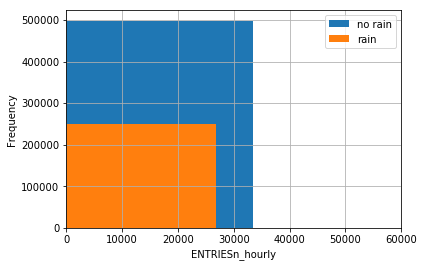

In [46]:
plt.figure()
(turnstile_weather_df.loc[:,'ENTRIESn_4hourly_actual'][turnstile_weather_df['rain'] == 0]).hist(bins = 200, label = 'no rain')
(turnstile_weather_df.loc[:,'ENTRIESn_4hourly_actual'][turnstile_weather_df['rain'] == 1]).hist(bins = 200, label = 'rain')
plt.xlim([0, 60000])
plt.legend()
plt.xlabel('ENTRIESn_hourly')
plt.ylabel('Frequency')

In [ ]:
turnstile_weather_df.loc[:,'ENTRIESn_4hourly_actual'][turnstile_weather_df['rain'] == 0]

In [ ]:
np.mean(turnstile_weather_df['ENTRIESn_4hourly_actual'][turnstile_weather_df['rain'] == 1])

In [ ]:
turnstile_weather_df.loc[1]

In [ ]:
turnstile_weather_df['UNIT'].nunique()

In [ ]:
turnstile_weather_df[turnstile_weather_df['UNIT'] == 'R001']

In [ ]:
turnstile_weather_df.shape

In [ ]:
turnstile_weather_df[['C/A','UNIT','ENTRIESn_4hourly']].groupby(['UNIT'], as_index = False).sum()

In [ ]:
turnstile_weather_df[turnstile_weather_df['ENTRIESn_4hourly'] < 0]

In [ ]:
True

In [ ]:
int(True)

In [ ]:
True * 5

In [ ]:
False * 5